# IMPORT DATASETS AND LIBRARIES

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read stock prices data
stock_price_df = pd.read_csv('Apple_Stock_5Y.csv')
stock_price_df

,Date,Close/Last,Volume,Open,High,Low
0,02/09/2022,$176.28,71285040,$176.05,$176.65,$174.9
1,02/08/2022,$174.83,74829220,$171.73,$175.35,$171.43
2,02/07/2022,$171.66,77251200,$172.86,$173.9458,$170.95
3,02/04/2022,$172.39,82465400,$171.68,$174.1,$170.68
4,02/03/2022,$172.9,89418070,$174.48,$176.2399,$172.12
...,...,...,...,...,...,...
1254,02/16/2017,$33.8363,90159440,$33.9175,$33.975,$33.7099
1255,02/15/2017,$33.8775,142314560,$33.88,$34.0675,$33.655
1256,02/14/2017,$33.755,132218000,$33.3675,$33.7725,$33.3125
1257,02/13/2017,$33.3225,91959920,$33.27,$33.455,$33.1875


In [3]:
import re

def clean_up_stock(text):
    text = re.sub(r'[^\w]', ' ', text)
    return text

In [4]:
col = ['Close/Last', 'Open', 'High', 'Low']
for i in col:
    stock_price_df[i] = stock_price_df[i].replace({r'\$':''}, regex = True)
    stock_price_df[i] = stock_price_df[i].astype(float)

stock_price_df

,Date,Close/Last,Volume,Open,High,Low
0,02/09/2022,176.2800,71285040,176.0500,176.6500,174.9000
1,02/08/2022,174.8300,74829220,171.7300,175.3500,171.4300
2,02/07/2022,171.6600,77251200,172.8600,173.9458,170.9500
3,02/04/2022,172.3900,82465400,171.6800,174.1000,170.6800
4,02/03/2022,172.9000,89418070,174.4800,176.2399,172.1200
...,...,...,...,...,...,...
1254,02/16/2017,33.8363,90159440,33.9175,33.9750,33.7099
1255,02/15/2017,33.8775,142314560,33.8800,34.0675,33.6550
1256,02/14/2017,33.7550,132218000,33.3675,33.7725,33.3125
1257,02/13/2017,33.3225,91959920,33.2700,33.4550,33.1875


In [5]:
df = stock_price_df.reset_index()['Close/Last']
df = df.iloc[::-1].reset_index()['Close/Last']
df

0        33.0300
1        33.3225
2        33.7550
3        33.8775
4        33.8363
          ...   
1254    172.9000
1255    172.3900
1256    171.6600
1257    174.8300
1258    176.2800
Name: Close/Last, Length: 1259, dtype: float64

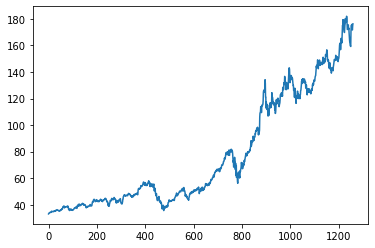

In [6]:
plt.plot(df)

# MinMax Scaler

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(np.array(df).reshape(-1,1))
print(df)

[[0.        ]
 [0.00196335]
 [0.00486643]
 ...
 [0.93052759]
 [0.95180561]
 [0.96153846]]


# Splitting Data to train test

In [8]:
training_size = int(len(df) * 0.7)
test_size = len(df) - training_size
train_data, test_data = df[0:training_size,:], df[training_size:len(df),:1]

In [9]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [10]:
time_step = 100
feature = 1
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [11]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , feature)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , feature)

In [12]:
### Create the Stacked LSTM model

from tensorflow.python.keras.layers import Dense, LSTM
from tensorflow.python.keras.models import Sequential

Using TensorFlow backend.


In [13]:
model= Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step, feature)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 7s 172ms/step - loss: 0.0091 - val_loss: 0.0983
Epoch 2/100
13/13 [==============================] - 2s 129ms/step - loss: 0.0022 - val_loss: 0.0123
Epoch 3/100
13/13 [==============================] - 2s 122ms/step - loss: 7.1060e-04 - val_loss: 0.0346
Epoch 4/100
13/13 [==============================] - 2s 122ms/step - loss: 5.0482e-04 - val_loss: 0.0149
Epoch 5/100
13/13 [==============================] - 2s 125ms/step - loss: 4.6212e-04 - val_loss: 0.0176
Epoch 6/100
13/13 [==============================] - 2s 119ms/step - loss: 4.1474e-04 - val_loss: 0.0092
Epoch 7/100
13/13 [==============================] - 2s 118ms/step - loss: 3.9634e-04 - val_loss: 0.0094
Epoch 8/100
13/13 [==============================] - 1s 116ms/step - loss: 3.8292e-04 - val_loss: 0.0061
Epoch 9/100
13/13 [==============================] - 2s 122ms/step - loss: 3.9101e-04 - val_loss: 0.0031
Epoch 10/100
13/13 [==============================] - 1s 115ms/

In [16]:
# Prediction and check performances
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [17]:
# Inverse transform to original close price
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [18]:
# Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

55.7742000629887

In [19]:
# Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

147.03022731160263

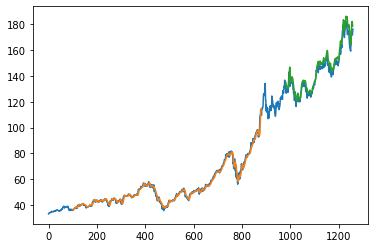

In [20]:
### Plotting
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [21]:
len(test_data)

378

In [22]:
x_input=test_data[278:].reshape(1,-1)
x_input.shape
x_input

array([[0.73775003, 0.74103907, 0.75728286, 0.76386092, 0.76446503,
        0.75406095, 0.73083635, 0.73701168, 0.72808431, 0.73580346,
        0.71224325, 0.72546651, 0.73144046, 0.74009934, 0.73748154,
        0.73687743, 0.72815143, 0.72412404, 0.74325413, 0.75050342,
        0.76198147, 0.77681568, 0.78017184, 0.78164854, 0.77634582,
        0.7760102 , 0.78057457, 0.77741979, 0.80238958, 0.78379648,
        0.77815814, 0.78527319, 0.79514029, 0.79158276, 0.7937307 ,
        0.78809236, 0.79057592, 0.77117734, 0.77084172, 0.78507182,
        0.78513894, 0.79185126, 0.80856491, 0.83796483, 0.85595382,
        0.85910861, 0.86172641, 0.86528393, 0.83084978, 0.853873  ,
        0.88783729, 0.88427977, 0.87750034, 0.8646127 , 0.88797154,
        0.92730568, 0.95348369, 0.94999329, 0.98281649, 0.95791381,
        0.94844946, 0.98180964, 0.93455497, 0.92703719, 0.91770707,
        0.93945496, 0.95724258, 0.96153846, 0.98872332, 0.98174252,
        0.98234662, 0.9744261 , 0.97019734, 1.  

In [23]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.737750033561552,
 0.7410390656463957,
 0.7572828567592966,
 0.7638609209289839,
 0.7644650288629347,
 0.7540609477782254,
 0.7308363538730032,
 0.7370116794200565,
 0.7280843066183381,
 0.7358034635521548,
 0.7122432541280709,
 0.7254665055712178,
 0.731440461806954,
 0.7400993421935831,
 0.7374815411464627,
 0.7368774332125119,
 0.7281514297221103,
 0.7241240434957713,
 0.743254128070882,
 0.7505034232782924,
 0.761981474023359,
 0.7768156799570413,
 0.7801718351456571,
 0.7816485434286481,
 0.7763458182306351,
 0.7760102027117733,
 0.7805745737682911,
 0.7774197878909921,
 0.8023895824942945,
 0.7837964827493625,
 0.7781581420324877,
 0.7852731910323535,
 0.7951402872868844,
 0.7915827627869515,
 0.7937307021076655,
 0.7880923613907908,
 0.7905759162303666,
 0.7711773392401665,
 0.770841723721305,
 0.7850718217210365,
 0.7851389448248088,
 0.7918512552020406,
 0.8085649080413481,
 0.8379648274936234,
 0.8559538193046049,
 0.8591086051819038,
 0.8617264062290241,
 0.865283930728956

In [24]:
# Prediction for next 10 days

lst_output=[]
n_steps=100
i=0
while(i<30):

    if len(temp_input)>100:
        # Shifting x_input to next day
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        # Predict next day
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.9823384]
101
1 day input [0.74103907 0.75728286 0.76386092 0.76446503 0.75406095 0.73083635
 0.73701168 0.72808431 0.73580346 0.71224325 0.72546651 0.73144046
 0.74009934 0.73748154 0.73687743 0.72815143 0.72412404 0.74325413
 0.75050342 0.76198147 0.77681568 0.78017184 0.78164854 0.77634582
 0.7760102  0.78057457 0.77741979 0.80238958 0.78379648 0.77815814
 0.78527319 0.79514029 0.79158276 0.7937307  0.78809236 0.79057592
 0.77117734 0.77084172 0.78507182 0.78513894 0.79185126 0.80856491
 0.83796483 0.85595382 0.85910861 0.86172641 0.86528393 0.83084978
 0.853873   0.88783729 0.88427977 0.87750034 0.8646127  0.88797154
 0.92730568 0.95348369 0.94999329 0.98281649 0.95791381 0.94844946
 0.98180964 0.93455497 0.92703719 0.91770707 0.93945496 0.95724258
 0.96153846 0.98872332 0.98174252 0.98234662 0.9744261  0.97019734
 1.         0.98449456 0.95240972 0.93280977 0.93395087 0.93408511
 0.95348369 0.95650423 0.93408511 0.93999195 0.91804269 0.89407974
 0.88253457 0.86843872 0.86313599 

In [25]:
print(lst_output)

[[0.9823384284973145], [0.9982374310493469], [1.018511176109314], [1.041205883026123], [1.0656278133392334], [1.0914450883865356], [1.1184195280075073], [1.146356225013733], [1.1751041412353516], [1.2045537233352661], [1.2346339225769043], [1.26530122756958], [1.2965307235717773], [1.3283066749572754], [1.3606120347976685], [1.3934202194213867], [1.426690697669983], [1.4603625535964966], [1.4943525791168213], [1.5285568237304688], [1.5628492832183838], [1.5970871448516846], [1.6311150789260864], [1.6647696495056152], [1.6973789930343628], [1.7271360158920288], [1.7558860778808594], [1.7839618921279907], [1.8113466501235962], [1.83766770362854]]


In [26]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [27]:
len(df)

1259

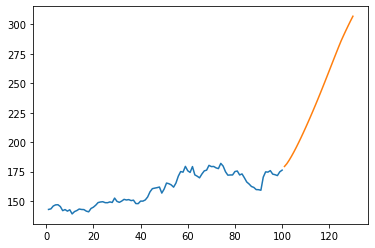

In [28]:
# Plot real 100 close value
plt.plot(day_new,scaler.inverse_transform(df[1159:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [29]:
df_new=df.tolist()
df_new.extend(lst_output)

In [30]:
len(df_new)

1289

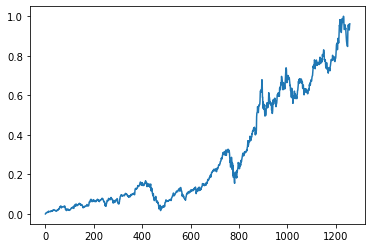

In [31]:
plt.plot(df)

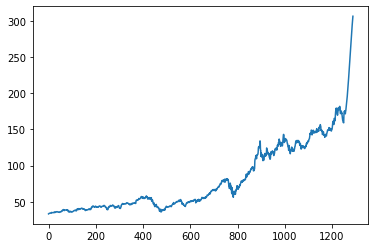

In [32]:
df_new=scaler.inverse_transform(df_new).tolist()
plt.plot(df_new)